# State of Health Prediction using LSTM and RUL Estimation using Deterministic Model

Create SoH prediction using LSTM and RUL estimation using Linear Regression for smartphone battery degradation. This notebook include EDA, Feature Engineering, Data Processing, Model Building, and Evaluation.

## Data Preprocessing

### Data Extraction

Extract smartphone data from Supabase collected from smartphone application

In [296]:
# Import necessary modules
import os
import sys

from utils import connect_to_db
from dotenv import load_dotenv
load_dotenv()

# Define database connection parameters
PORT = os.getenv("PORT")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
DATABASE = os.getenv("DATABASE")

# Check connection parameters
if not all([PORT, USERNAME, PASSWORD, HOST, DATABASE]):
    print("Error: One or more database connection parameters are missing.")
    sys.exit(1)

# Establish connection to the database
conn = connect_to_db(HOST, PORT, DATABASE, USERNAME, PASSWORD)

Connection to database established successfully.


### Data Convertion

Convert extracted data from Supabase into dataframe format, ensure all the columns matches the data type.

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Extract data from the database
with conn.cursor() as cursor:
  cursor.execute("SELECT * FROM public.raw_metrics ORDER BY device_id, created_at ASC")
  data = cursor.fetchall()
  # Convert to DataFrame
  df = pd.DataFrame(data, columns=[desc[0] for desc in cursor.description])

# Ensure sorted data
df["created_at"] = pd.to_datetime(df["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)

In [298]:
# Convert to Jakarta timezone
import pytz
df['created_at'] = df['created_at'].dt.tz_convert('Asia/Jakarta')
df['ts_utc'] = df['ts_utc'].dt.tz_convert('Asia/Jakarta')

# Check null values
df.isnull().sum()

# Drop unused columns
df.drop(["charge_source", "energy_nwh", "cycles_count", "current_avg_ua"], axis=1).head()

,id,user_id,device_id,ts_utc,net_type,channel_quality,rx_total_bytes,tx_total_bytes,batt_voltage_mv,batt_current_ua,batt_temp_c,is_charging,battery_health,battery_level,charge_counter_uah,battery_capacity_pct,fg_pkg,created_at
0,5f9a61dc-10af-462a-af07-00cc8e452677,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:10.349366+07:00,WiFi,-56,2014928638,112746489,3703,623000,35.5,False,GOOD,16,518000,16,Device Analytics,2025-11-10 20:26:11.940321+07:00
1,6057bf9c-b150-4ec8-8786-7d731bb7ec94,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:11.805850+07:00,WiFi,-56,2014928978,112747759,3703,623000,35.5,False,GOOD,16,518000,16,Device Analytics,2025-11-10 20:26:12.630878+07:00
2,d55733e0-af40-45b7-8380-d39ba4f92bec,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:29:59.093424+07:00,WiFi,-54,2045926067,114374859,3586,653000,36.1,False,GOOD,15,488000,15,Instagram,2025-11-10 20:30:00.489796+07:00
3,f178b802-d1d3-4280-b371-a4460cccdeed,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:53:21.834407+07:00,WiFi,-59,2055732576,115764715,3467,1524000,32.5,False,GOOD,14,437000,14,Device Analytics,2025-11-10 20:53:22.714987+07:00
4,75c65cc2-7db9-4d2e-aab7-9a0caced7ce5,None,22021211RG-0940e2943d7b49eb,2025-11-10 21:09:33.882115+07:00,WiFi,-60,2062366807,117028496,4305,-4525000,36.0,True,GOOD,20,612000,20,Discord,2025-11-10 21:09:34.698560+07:00


### Histogram Plot

Plot the data columns as histogram plot to extract the insights

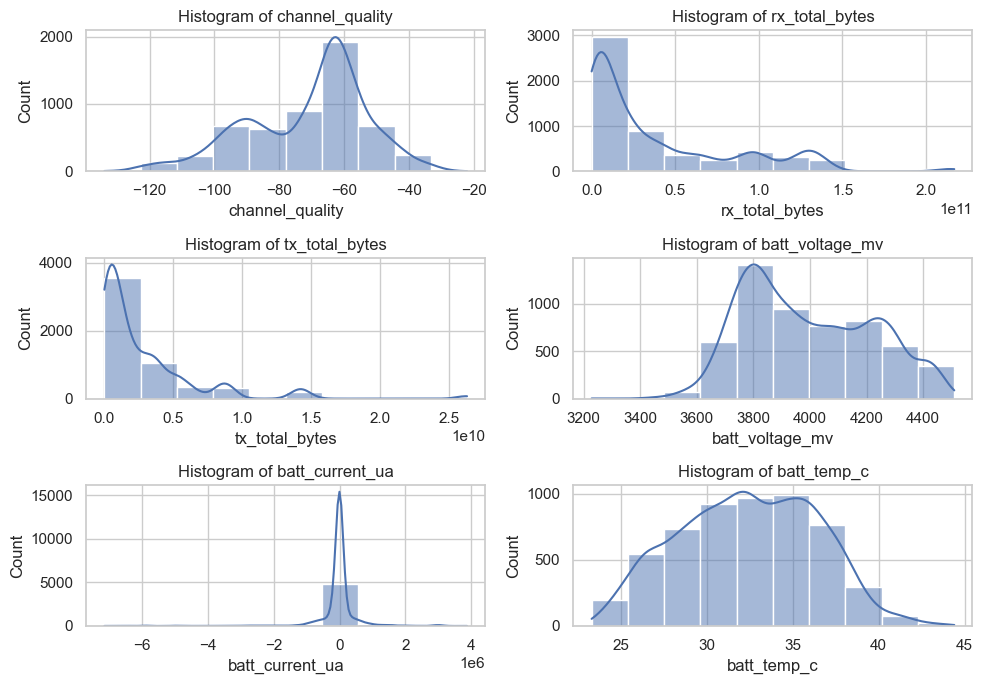

In [299]:
import seaborn as sns

plt.rcParams['agg.path.chunksize'] = 20000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 7))

# List of numerical columns
numerical_cols = ['channel_quality', 'rx_total_bytes', 'tx_total_bytes', 'batt_voltage_mv',
'batt_current_ua', 'batt_temp_c', "charge_counter", "battery_capacity_pct"]

# Plot histograms for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(df[col], bins=10, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

### Throughput and Energy Calculation

Calculate throughput and energy over time from smartphone data collected from Supabase

In [300]:
# Ensure 'created_at' is in datetime format
df["created_at"] = pd.to_datetime(df["created_at"])

# Calculate time difference in seconds
df["delta_t"] = df["created_at"].diff().dt.total_seconds().fillna(0)

# Convert voltage from mV to V and current from uA to A
df["batt_voltage_v"] = df["batt_voltage_mv"] / 1000
df["batt_current_a"] = df["current_avg_ua"] / 1_000_000

# Energi per step (Joule)
df["energy_over_time"] = df["batt_voltage_v"] * df["batt_current_a"] * df["delta_t"]
df["energy_over_time"] = df["energy_over_time"] / 3600

# Calculate througput
df = df.sort_values("ts_utc")
df["delta_t"] = df["ts_utc"].diff().dt.total_seconds()
df["delta_tx"] = df["tx_total_bytes"].diff()
df["delta_rx"] = df["rx_total_bytes"].diff()

df["throughput_total_bps"] = (df["delta_tx"] + df["delta_rx"]) * 8 / df["delta_t"]

# Drop NaN values
df.loc[df["delta_t"] <= 0, "throughput_total_bps"] = np.nan
df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)

df["throughput_total_gb"] = df["throughput_total_bps"] / 1e6

C:\Users\Fadel\AppData\Local\Temp\ipykernel_23156\3663813871.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)


### Calculate Energy per Bit

Calculate energy per bit using Throughput metrics. The equation derived from *Energy Model for Data Transfer* paper, alpha and beta values used from paper. 

In [302]:
# Replace zero throughput with NaN to avoid division by zero
df["throughput_total_bps"] = df["throughput_total_bps"].replace(0, np.nan)

# Cofficient from paper
alpha_tx = 446.2936  # nJ/bit
beta_tx = 3.381132   # nJ/bit
alpha_rx = 357.5443  # nJ/bit
beta_rx = 1.969068   # nJ/bit

# Energy per bit calculation
df["energy_per_bit_tx"] = (alpha_tx / df["throughput_total_bps"]) + beta_tx
df["energy_per_bit_rx"] = (alpha_rx / df["throughput_total_bps"]) + beta_rx
df["energy_per_bit_tx_J"] = df["energy_per_bit_tx"] * 1e-9
df["energy_per_bit_rx_J"] = df["energy_per_bit_rx"] * 1e-9

# Energy per bit total calculation
df["energy_per_bit_avg_J"] = (df["energy_per_bit_tx_J"] + df["energy_per_bit_rx_J"]) / 2

# Preview result
df[[
  "ts_utc",
  "throughput_total_bps",
  "energy_per_bit_tx_J",
  "energy_per_bit_rx_J",
  "energy_per_bit_avg_J",
]].head()

,ts_utc,throughput_total_bps,energy_per_bit_tx_J,energy_per_bit_rx_J,energy_per_bit_avg_J
4513,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN,NaN
4514,2025-10-31 05:53:30.429297+07:00,1.313596e+06,3.381472e-09,1.969340e-09,2.675406e-09
4515,2025-10-31 06:08:32.072450+07:00,3.407266e+06,3.381263e-09,1.969173e-09,2.675218e-09
4516,2025-10-31 06:23:33.918787+07:00,4.534018e+06,3.381230e-09,1.969147e-09,2.675189e-09
4517,2025-10-31 06:38:35.969953+07:00,5.097230e+06,3.381220e-09,1.969138e-09,2.675179e-09


Calculate battery cost of traffic using average voltage and energy per bit

In [303]:
# Average voltage
V_avg = df["batt_voltage_v"].mean()

# Calculate Battery Cost of Traffic (BoT)
# BoT = (E_b * (8 × 10^9) / V_avg) × (1000 / 3600)
df["BoT_mAh_per_Gbps"] = (df["energy_per_bit_avg_J"] * (8 * 1e9) / V_avg) * (1000 / 3600)

# Preview result
df[["ts_utc", "throughput_total_bps", "energy_per_bit_avg_J", "BoT_mAh_per_Gbps"]].head()

,ts_utc,throughput_total_bps,energy_per_bit_avg_J,BoT_mAh_per_Gbps
4513,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN
4514,2025-10-31 05:53:30.429297+07:00,1.313596e+06,2.675406e-09,1.489480
4515,2025-10-31 06:08:32.072450+07:00,3.407266e+06,2.675218e-09,1.489375
4516,2025-10-31 06:23:33.918787+07:00,4.534018e+06,2.675189e-09,1.489359
4517,2025-10-31 06:38:35.969953+07:00,5.097230e+06,2.675179e-09,1.489353


## Application Usage Analysis

Create bar plot to see most usage application for every devices collected from smartphone battery application.

C:\Users\Fadel\AppData\Local\Temp\ipykernel_23156\113029621.py:11: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  plt.tight_layout()
c:\College\Bachelor\smartphone-battery-notebook\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


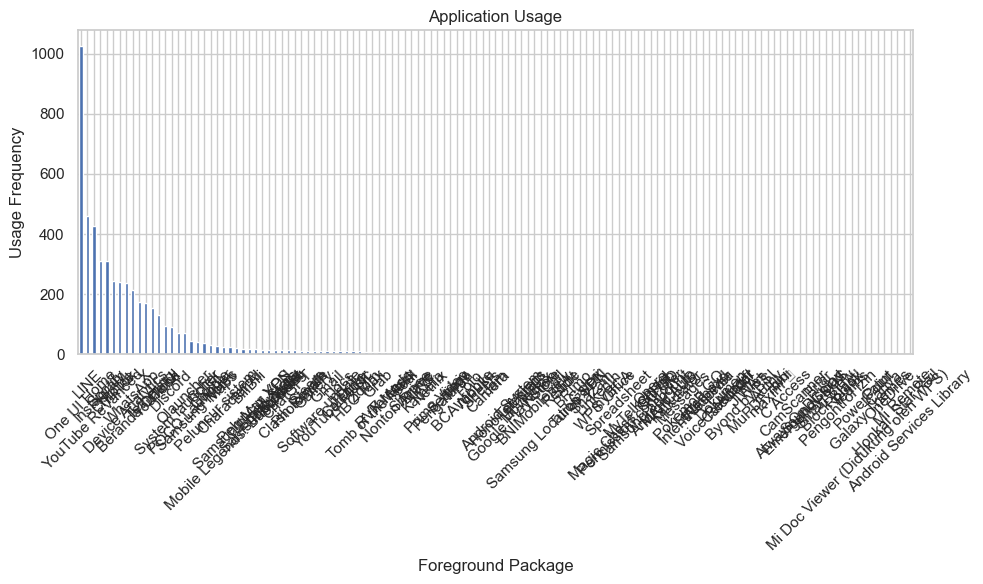

In [304]:
# Count the occurrences of each package
package_counts = df['fg_pkg'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
package_counts.plot(kind='bar')
plt.title('Application Usage')
plt.xlabel('Foreground Package')
plt.ylabel('Usage Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Detect infinix devices

In [328]:
# Detect all Infinix devices in df_all
infinix_devices = sorted([
  d for d in df["device_id"].unique()
  if "Infinix" in str(d)
])
print("Infinix devices detected:", infinix_devices)


Infinix devices detected: []


## Model Building

Create LSTM model to predict smartphone battery State of Health.

In [306]:
import os
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [307]:
df = df[~df["device_id"].isin(infinix_devices)].copy()
print("Remaining devices:", df["device_id"].nunique())

Remaining devices: 23


### Calculate State of Health and Battery Cycles

Create function to calculate state of health and battery cycles for LSTM prediction

In [308]:
from utils import calculate_soh_and_cycles

# Merge device
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna(subset=["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)


# Merge SoH calculation for all devices
df_all = (
  df
  .groupby("device_id", group_keys=False)
  .apply(lambda g: calculate_soh_and_cycles(g))
)

df_all["SoH_filled"] = df_all["SoH_smooth"].where(
  df_all["SoH_smooth"].notna(), df_all["SoH"]
)

df_all["SoH_filled"] = (
  df_all.groupby("device_id")["SoH_filled"]
    .transform(lambda s: s.ffill().bfill())
)

C:\Users\Fadel\AppData\Local\Temp\ipykernel_23156\3815605544.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calculate_soh_and_cycles(g))


### Device Summary

Create device summary to check minimum and maximum State of Health values

In [329]:
# Device summary
summary = (df_all.groupby("device_id")["SoH_filled"].agg(["count","min","max"]).sort_values("max", ascending=False))
summary

,count,min,max
device_id,,,
24117RN76O-af9a140a5e0ea0de,43,0.796485,1.048501
SM-S931B-57bc0e2d9eac7750,954,1.000000,1.000000
2406APNFAG-4b17a6ddf26cd705,144,0.736842,0.736842
2311DRK48G-b135dcd1d7e9320f,413,0.736842,0.736842
SM-A336E-c471046323c8859c,315,0.736842,0.736842
SM-A155F-7d69b63bc200801a,323,0.736842,0.736842
SM-A356E-4e32dd36015962aa,259,0.736842,0.736842
SM-A546E-1cf82eec40a3542b,202,0.736842,0.736842
SM-A546E-701861f29b4d5913,334,0.736842,0.736842


### Quarantine Devices

Exclude devices that had incomplete State of Health data

In [312]:
from utils import quarantine_device

bad_devices = quarantine_device(df_all)
print("Bad devices:", bad_devices)

Bad devices: ['22021211RG-0940e2943d7b49eb', '23124RA7EO-3eb11a599d8b922d', '2312DRA50G-223024e791e6150d', 'Redmi Note 9 Pro-d2c7435268ff2367', 'SM-T505-280eb41faa621df0']


Sanity check to ensure the State of Health between 0 - 1.2

In [330]:
# Sanity checks
print("Devices:", df_all["device_id"].nunique(), "Rows:", len(df_all))
assert (df_all["SoH_filled"].dropna().between(0, 1.2)).all()

# EFC per devices
ok = df_all.groupby("device_id")["EFC"].apply(lambda s: (s.diff().fillna(0) >= -1e-9).all())
print("EFC monotonic all devices:", ok.all())

Devices: 23 Rows: 5282
EFC monotonic all devices: True


### Feature Processing

Create Z-Score normalization, also define target and feature columns

In [314]:
from utils import add_aging_features

# Define base columns for aging features
AGING_BASE_COLS = [
  "batt_voltage_v",
  "batt_temp_c",
  "throughput_total_gb",
  "energy_per_bit_avg_J",
  "SoH_filled",
  "EFC",
  "soh_trend",
  "efc_delta",
  "temp_ema",
  "temp_max_win",
  "tp_ema",
  "epb_ema",
]

# Function to add per-device z-score normalization
def add_per_device_zscore(df, cols=AGING_BASE_COLS):
  df = df.copy()
  def _z_per_dev(g):
    for c in cols:
      if c not in g.columns:
        continue
      x = g[c].astype(float)
      mu = x.mean()
      sigma = x.std(ddof=0)
      if sigma == 0 or np.isnan(sigma):
        g[c + "_z"] = 0.0
      else:
        g[c + "_z"] = (x - mu) / sigma
    return g
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)
  return df

# Apply per-device z-score normalization
df_fe = add_aging_features(df_all)
df_fe = add_per_device_zscore(df_fe)

# Define final feature columns
feature_cols = [
  "batt_voltage_v", "batt_temp_c",
  "throughput_total_gb", "energy_per_bit_avg_J",
  "EFC", "soh_trend", "efc_delta",
  "temp_ema", "temp_max_win", "tp_ema", "epb_ema",
  "batt_voltage_v_z", "batt_temp_c_z",
  "throughput_total_gb_z", "energy_per_bit_avg_J_z",
  "SoH_filled_z", "EFC_z", "soh_trend_z",
]

# Define target column
target_col_soh = "SoH_filled"

c:\College\Bachelor\smartphone-battery-notebook\utils.py:364: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id").apply(_per_dev).reset_index(drop=True)
C:\Users\Fadel\AppData\Local\Temp\ipykernel_23156\3227138959.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)


### Train Test Split

Split data into train, test, and split variation. Also exclude devices that has 100% State of Health

In [ ]:
# Set random seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Split device IDs into train, validation, and test sets
device_ids = df_fe["device_id"].dropna().unique()

# Exclude Samsung S25 devices
s25_ids = [d for d in device_ids if str(d).startswith("SM-S931B")]
other_ids = np.array([d for d in device_ids if d not in s25_ids])

# Check devices
print("Total devices:", len(device_ids))
print("S23 (SM-S931B) devices:", s25_ids)
print("Other devices:", len(other_ids))

# Shuffle devices
rng.shuffle(other_ids)

# 70% train, 15% val, 15% test
n_train = int(0.7 * len(device_ids))
n_val   = int(0.15 * len(device_ids))

# Assign device IDs to each set
train_ids = device_ids[:n_train]
val_ids   = device_ids[n_train:n_train+n_val]
test_ids  = device_ids[n_train+n_val:]

# Add S25 to train set
train_ids = np.concatenate([train_ids, np.array(s25_ids, dtype=object)])

# Create DataFrames for each set
df_train = df_fe[df_fe["device_id"].isin(train_ids)].copy()
df_val   = df_fe[df_fe["device_id"].isin(val_ids)].copy()
df_test  = df_fe[df_fe["device_id"].isin(test_ids)].copy()

print(len(train_ids), len(val_ids), len(test_ids))

Total devices: 23
S23 (SM-S931B) devices: ['SM-S931B-57bc0e2d9eac7750']
Other devices: 22
17 3 4


### Subset and Scaler

Scale the data and create subset

In [316]:
from sklearn.preprocessing import StandardScaler

# Define preparation function
def prepare_subset(df, feature_cols, target_col):
  df = df.sort_values(["device_id", "created_at"]).copy()
  X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
  y = df[target_col].astype(float).values
  dev = df["device_id"].astype(str).values
  ts  = pd.to_datetime(df["created_at"]).values
  efc = df["EFC"].astype(float).values
  return X, y, dev, ts, efc

X_tr_raw, y_tr, dev_tr, t_tr, efc_tr = prepare_subset(df_train, feature_cols, target_col_soh)
X_va_raw, y_va, dev_va, t_va, efc_va = prepare_subset(df_val,   feature_cols, target_col_soh)
X_te_raw, y_te, dev_te, t_te, efc_te = prepare_subset(df_test,  feature_cols, target_col_soh)

scaler_X = StandardScaler().fit(X_tr_raw)
X_tr = scaler_X.transform(X_tr_raw)
X_va = scaler_X.transform(X_va_raw)
X_te = scaler_X.transform(X_te_raw)


### Time Sequence

Create function to make a sequence using 24 lookback

In [317]:
def make_sequences(X, y, dev, ts, efc, lookback):
  X_seq, y_seq, dev_seq, t_seq, efc_seq = [], [], [], [], []
  # indeks mulai per device
  df_idx = pd.DataFrame({"device_id": dev, "idx": np.arange(len(dev))})
  for d, rows in df_idx.groupby("device_id"):
    idxs = rows["idx"].values
    if len(idxs) <= lookback:
      continue
    for i in range(lookback, len(idxs)):
      j = idxs[i]
      j0 = idxs[i-lookback:i]
      X_seq.append(X[j0, :])
      y_seq.append(y[j])
      dev_seq.append(d)
      t_seq.append(ts[j])
      efc_seq.append(efc[j])
  return (
    np.array(X_seq, dtype=np.float32),
    np.array(y_seq, dtype=np.float32),
    np.array(dev_seq),
    np.array(t_seq),
    np.array(efc_seq, dtype=np.float32),
  )

# Define lookback window
lookback = 24

# Prepare sequences
X_train, y_train, dev_tr_seq, t_tr_seq, efc_tr_seq = make_sequences(X_tr, y_tr, dev_tr, t_tr, efc_tr, lookback)
X_val,   y_val,   dev_va_seq, t_va_seq, efc_va_seq = make_sequences(X_va, y_va, dev_va, t_va, efc_va, lookback)
X_test,  y_test,  dev_te_seq, t_te_seq, efc_te_seq = make_sequences(X_te, y_te, dev_te, t_te, efc_te, lookback)

print("Train seq:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train seq: (3700, 24, 18) Val: (662, 24, 18) Test: (1318, 24, 18)


In [318]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Define features
n_features = X_train.shape[-1]

# Define LSTM model for SoH prediction
inp = layers.Input(shape=(lookback, n_features))
x = layers.Masking(mask_value=0.0)(inp)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
out_soh = layers.Dense(1, activation="sigmoid", name="soh_out")(x)  # 0–1

# Compile model
model_soh = models.Model(inputs=inp, outputs=out_soh)
model_soh.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss="mse",
  metrics=["mae"]
)
model_soh.summary()

cb = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),]

history = model_soh.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=64,
  callbacks=cb,
  verbose=1,
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 24, 18)    │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_6 (Masking) │ (None, 24, 18)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_6 (Any)         │ (None, 24)        │          0 │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 24, 64)    │     21,248 │ masking_6[0][0],  │
│                     │                   │            │ any_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 24, 64)    │          0 │ lstm_12[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 32)        │     12,416 │ dropout_12[0][0], │
│                     │                   │            │ any_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      1,056 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soh_out (Dense)     │ (None, 1)         │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,753 (135.75 KB)

 Trainable params: 34,753 (135.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0234 - mae: 0.1099 - val_loss: 0.0030 - val_mae: 0.0328
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0030 - val_mae: 0.0265
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - mae: 0.0228 - val_loss: 0.0044 - val_mae: 0.0297
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2849e-04 - mae: 0.0187 - val_loss: 0.0061 - val_mae: 0.0352
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.5117e-04 - mae: 0.0148 - val_loss: 0.0069 - val_mae: 0.0373
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4238e-04 - mae: 0.0129 - val_loss: 0.0068 - val_mae: 0.0388
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6708e-04 - mae: 0.0110 - val_loss: 0.0077 - val_mae: 0.0454
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1766e-04 - mae: 0.0102 - val_loss: 0.0076 - val_mae: 0.0463
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━

In [319]:
y_pred = model_soh.predict(X_test).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred) if np.var(y_test) > 1e-6 else np.nan
print(f"SoH — RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
SoH — RMSE=0.0406, MAE=0.0170, R2=0.8810


## RUL Estimation

In [320]:
from sklearn.linear_model import LinearRegression

def estimate_global_degradation_rate(df, soh_col="SoH_filled", efc_col="EFC"):
  slopes = []
  for dev, g in df.groupby("device_id"):
    g = g.dropna(subset=[soh_col, efc_col]).copy()
    if len(g) < 10:
      continue
    if g[efc_col].max() - g[efc_col].min() < 0.05:
      continue  
    X = g[[efc_col]].values
    y = g[soh_col].values
    reg = LinearRegression().fit(X, y)
    b = reg.coef_[0]
    if b < -1e-5:  # hanya slope negatif yang meaningful
      slopes.append(b)
  if not slopes:
    k = 0.2 / 500.0
    print("Warning: no valid slopes, using heuristic k =", k)
    return k
  k = -np.median(slopes)
  print("Estimated global degradation rate k (SoH drop per EFC):", k)
  return k

k_global = estimate_global_degradation_rate(df_train)
SoH_eol  = 0.7
print(f"SoH Drop per EFC: {k_global:.6f}, EOL SoH Threshold: {SoH_eol:.2f}")

SoH Drop per EFC: 0.000400, EOL SoH Threshold: 0.70


In [321]:
def estimate_hours_per_cycle(df, efc_col="EFC", time_col="created_at"):
  df = df.dropna(subset=[efc_col, time_col]).copy()
  df[time_col] = pd.to_datetime(df[time_col])
  df = df.sort_values(time_col)
    
  total_hours = (df[time_col].max() - df[time_col].min()).total_seconds() / 3600.0
  total_efc   = df[efc_col].max() - df[efc_col].min()
  if total_efc <= 0:
      return None
  return total_hours / total_efc

h_per_cycle = estimate_hours_per_cycle(df_train)
print("Approx hours per EFC:", h_per_cycle)

Approx hours per EFC: 35.20186505091243


In [322]:
# Compute RUL from SoH
def compute_rul_from_soh(soh_pred, k, soh_eol=0.65, hours_per_cycle=None):
  soh_pred = np.asarray(soh_pred, dtype=float)
  soh_pred = np.clip(soh_pred, 0.0, 1.0)
  
  # RUL in EFC
  rul_cycles = (soh_pred - soh_eol) / k
  rul_cycles = np.maximum(rul_cycles, 0.0)
  if hours_per_cycle is not None:
    rul_hours = rul_cycles * hours_per_cycle
    return rul_cycles, rul_hours
  return rul_cycles, None

rul_cycles_pred, rul_hours_pred = compute_rul_from_soh(
  soh_pred=y_pred,
  k=k_global,
  soh_eol=SoH_eol,
  hours_per_cycle=h_per_cycle,
)

print("RUL_cycles_pred min/max:", rul_cycles_pred.min(), rul_cycles_pred.max())
if rul_hours_pred is not None:
  print("RUL_hours_pred min/max:", rul_hours_pred.min(), rul_hours_pred.max())


RUL_cycles_pred min/max: 0.0 722.5025892257692
RUL_hours_pred min/max: 0.0 25433.438644860344


## Plot Metrics

Create line plot for every prediction metrics to extract insights for each devices

### Create Dataframe

Create dataframe including SoH, RUL, and battery cycles for plot

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

res = pd.DataFrame({
  "device_id": pd.Series(dev_te_seq, dtype=str),
  "created_at": pd.to_datetime(t_te_seq, errors="coerce"),
  "SoH_true":  y_test.astype(float).ravel(),
  "SoH_pred":  y_pred.astype(float).ravel(),
  "RUL_cycles": rul_cycles_pred.astype(float).ravel(),
  "RUL_hours":  rul_hours_pred.astype(float).ravel() if rul_hours_pred is not None else np.nan,
  "EFC": efc_te_seq.astype(float)
})

# Bersihkan NaT / NaN waktu
res = res.dropna(subset=["created_at"]).copy()
print(res.head())

                   device_id                 created_at  SoH_true  SoH_pred  \
0  SM-S921B-d2c3f5675ad3a14d 2025-11-11 14:28:34.208924  0.736842  0.756012   
1  SM-S921B-d2c3f5675ad3a14d 2025-11-11 14:45:19.430943  0.736842  0.763975   
2  SM-S921B-d2c3f5675ad3a14d 2025-11-11 15:00:42.654240  0.736842  0.770120   
3  SM-S921B-d2c3f5675ad3a14d 2025-11-11 15:15:43.441793  0.736842  0.775045   
4  SM-S921B-d2c3f5675ad3a14d 2025-11-11 15:31:20.918410  0.736842  0.778399   

   RUL_cycles    RUL_hours       EFC  
0  140.031248  4929.361107  0.000438  
1  159.936368  5630.058459  0.000470  
2  175.300360  6170.899606  0.000501  
3  187.611997  6604.292205  0.000517  
4  195.998520  6899.513439  0.000517  


### Smoothing

Create smoothing for State of Health and monotonic RUL

In [ ]:
# Sort values by device_id and EFC
res = res.sort_values(["device_id", "EFC"]).reset_index(drop=True)
res["SoH_pred_smooth"] = (
  res
    .groupby("device_id")["SoH_pred"]
    .transform(lambda s: (
      s.rolling(window=7, min_periods=1, center=True).mean()
  ))
)

# Smoothing function for RUL to be monotonic decreasing
def smooth_and_monotonic_rul(series, window=7):
  smoothed = series.rolling(window=window, min_periods=1, center=True).mean()
  arr = smoothed.to_numpy()
  mono = np.maximum.accumulate(arr[::-1])[::-1]
  return pd.Series(mono, index=series.index)

# Apply smoothing and monotonic constraint to RUL
res["RUL_cycles_smooth"] = (
  res
    .groupby("device_id")["RUL_cycles"]
    .transform(lambda s: smooth_and_monotonic_rul(s, window=7))
)


### Plot SoH and RUL

Create function to plot SoH and RUL based on battery cycles

In [325]:
def plot_soh_rul_vs_cycle(df_plot, device_id, savepath=None):
  # Filter data untuk device tsb
  g = df_plot[df_plot["device_id"] == device_id].copy()
  g = g.dropna(subset=["EFC"])
  if g.empty:
    print(f"[WARN] Tidak ada data EFC untuk device {device_id} setelah merge.")
    return
  g = g.sort_values("EFC")
  g["SoH_true_pct"] = g["SoH_true"] * 100.0
  g["SoH_pred_smooth_pct"] = g["SoH_pred_smooth"] * 100.0
  fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
  # --- Plot SoH vs EFC ---
  ax1 = axes[0]
  ax1.plot(g["EFC"], g["SoH_true_pct"], label="SoH True (%)")
  ax1.plot(g["EFC"], g["SoH_pred_smooth_pct"], label="SoH Pred (%)", alpha=0.8)
  ax1.set_ylabel("SoH (%)")
  ax1.legend(loc="best")
  ax1.grid(True, alpha=0.3)
  ax1.set_title(f"SoH & RUL terhadap Siklus — {device_id}")
  # --- Plot RUL vs EFC ---
  ax2 = axes[1]
  ax2.plot(g["EFC"], g["RUL_cycles_smooth"], label="RUL (cycles)")
  ax2.set_xlabel("Equivalent Full Cycles (EFC)")
  ax2.set_ylabel("RUL (cycles)")
  ax2.legend(loc="best")
  ax2.grid(True, alpha=0.3)
  plt.tight_layout()
  if savepath:
    plt.savefig(savepath, dpi=200)
    print("Saved:", savepath)
    plt.close()
  else:
    plt.show()

test_devices = res["device_id"].unique()
print(test_devices)


['SM-S921B-d2c3f5675ad3a14d' 'SM-S926B-1ccc6862dc88e6b9'
 'SM-S931B-57bc0e2d9eac7750' 'SM-T505-280eb41faa621df0']


Create SoH and RUL plot for test devices

In [326]:
devices = [0, 1, 2, 3]
for i in devices:
  sample_dev = test_devices[i]
  plot_soh_rul_vs_cycle(res, sample_dev, savepath=f"exports/plots_pred/{sample_dev}_soh_rul_cycle.png")

Saved: exports/plots_pred/SM-S921B-d2c3f5675ad3a14d_soh_rul_cycle.png
Saved: exports/plots_pred/SM-S926B-1ccc6862dc88e6b9_soh_rul_cycle.png
Saved: exports/plots_pred/SM-S931B-57bc0e2d9eac7750_soh_rul_cycle.png
[WARN] Tidak ada data EFC untuk device SM-T505-280eb41faa621df0 setelah merge.
